In [77]:
from typing import List, Dict, NamedTuple, Optional, Tuple
from collections import Counter, namedtuple, defaultdict
import math
import matplotlib.pyplot as plt
import random
from scratch.probability import inverse_normal_cdf
from scratch.statistics import correlation, standard_deviation
from scratch.linear_algebra import Vector, Matrix, make_matrix, distance, vector_mean, subtract, magnitude, dot, scalar_multiply
from scratch.gradient_descent import gradient_step
from datetime import datetime
from dataclasses import dataclass
from dateutil.parser import parse
import re
import csv
import tqdm

In [ ]:
def bucketize(point: float, bucket_size: float) -> float:
    return bucket_size * math.floor(point / bucket_size)


def make_histogram(points: List[float], bucket_size: float) -> Dict[float, int]:
    return Counter(bucketize(point, bucket_size) for point in points)


def plot_histogram(points: List[float], bucket_size: float, title: str = "") -> None:
    histogram = make_histogram(points, bucket_size)

    plt.bar(histogram.keys(), histogram.values(), width=bucket_size)
    plt.title(title)
    plt.show()

In [3]:
uniform = [200 * random.random() - 100 for _ in range(10000)]

normal = [57 * inverse_normal_cdf(random.random()) for _ in range(10000)]

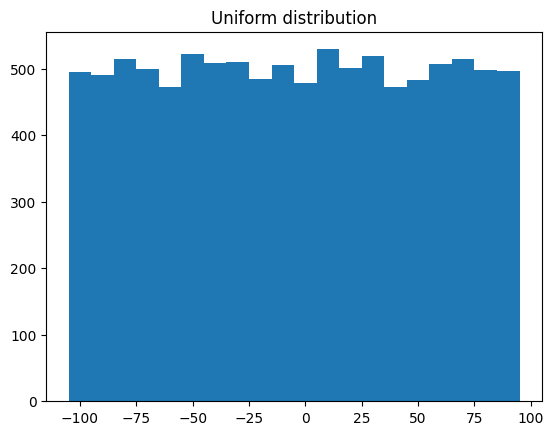

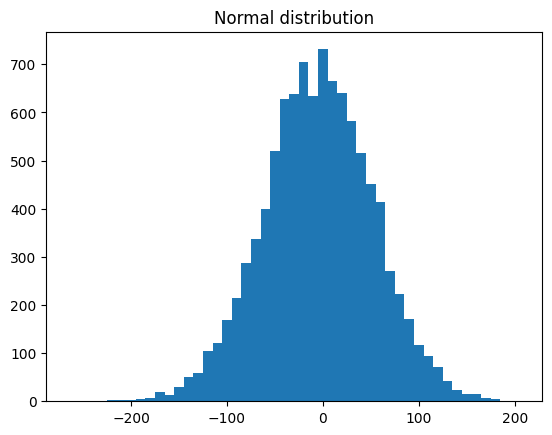

In [4]:
plot_histogram(uniform, 10, "Uniform distribution")

plot_histogram(normal, 10, "Normal distribution")

In [5]:
def random_normal():
    return inverse_normal_cdf(random.random())

In [6]:
xs = [random_normal() for _ in range(1000)]
ys1 = [x + random_normal() / 2 for x in xs]
ys2 = [-x + random_normal() / 2 for x in xs]

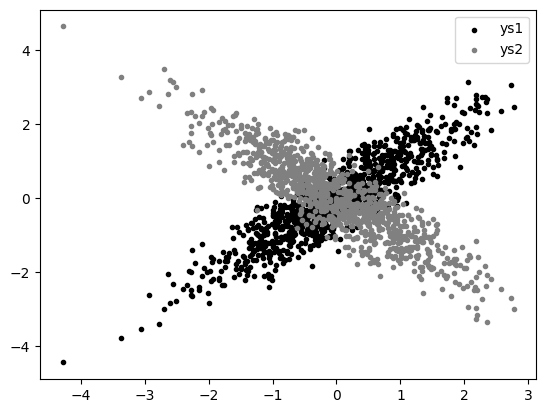

In [7]:
plt.scatter(xs, ys1, marker=".", color="black", label="ys1")
plt.scatter(xs, ys2, marker=".", color="gray", label="ys2")
plt.legend()
plt.show()

In [8]:
print(correlation(xs, ys1))

print(correlation(xs, ys2))

0.9029867259815852
-0.8905891562881733


In [ ]:
def correlation_matrix(data: List[Vector]) -> Matrix:
    correlation_ij = lambda i, j: (
        round(correlation(data[i], data[j]), 3) if i != j else 1.0
    )

    return make_matrix(len(data), len(data), correlation_ij)

In [ ]:
num_points = 100


def random_row() -> List[float]:
    row = [0, 0, 0, 0]
    row[0] = random_normal()
    row[1] = -5 * row[0] + random_normal()
    row[2] = row[0] + row[1] + 5 * random_normal()
    row[3] = 6 if row[2] > -2 else 0

    return row

In [11]:
corr_rows = [random_row() for _ in range(num_points)]
corr_data = [list(col) for col in zip(*corr_rows)]

In [12]:
corr_matrix = correlation_matrix(corr_data)
for m in corr_matrix:
    print(m)

[1.0, -0.982, -0.56, -0.427]
[-0.982, 1.0, 0.595, 0.449]
[-0.56, 0.595, 1.0, 0.819]
[-0.427, 0.449, 0.819, 1.0]


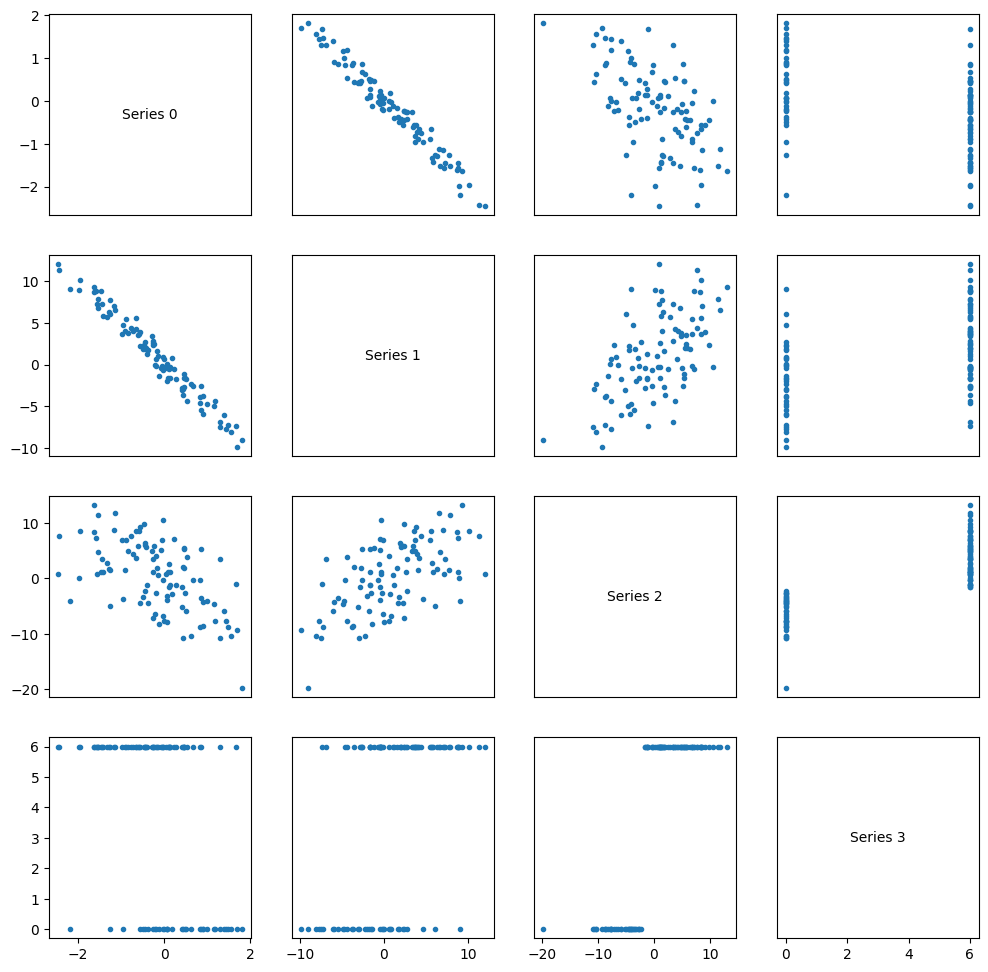

In [ ]:
num_vectors = len(corr_data)
fig, ax = plt.subplots(num_vectors, num_vectors, figsize=(12, 12))

for i in range(num_vectors):
    for j in range(num_vectors):
        if i != j:
            ax[i][j].scatter(corr_data[j], corr_data[i], marker=".")

        else:
            ax[i][j].annotate(
                f"Series {i}",
                (0.5, 0.5),
                xycoords="axes fraction",
                ha="center",
                va="center",
            )

        if i < num_vectors - 1:
            ax[i][j].xaxis.set_visible(False)
        if j > 0:
            ax[i][j].yaxis.set_visible(False)

ax[-1][-1].set_xlim(ax[0][-1].get_xlim())
ax[0][0].set_ylim(ax[0][1].get_ylim())
plt.show()

In [ ]:
StockPrice = namedtuple("StockPrice", ["symbol", "date", "closing_price"])
price = StockPrice("MSFT", datetime(2018, 12, 14), 106.03)

print(price.symbol)
print(price.date)
print(price.closing_price)

MSFT
2018-12-14 00:00:00
106.03


In [ ]:
class StockPrice(NamedTuple):
    symbol: str
    date: datetime
    closing_price: float

    def is_high_tech(self) -> bool:
        return self.symbol in ["MSFT", "GOOG", "FB", "AMZ", "AAPL"]


price = StockPrice("MSFT", datetime(2018, 12, 14), 106.03)

print(price.symbol)
print(price.date)
print(price.closing_price)
print(price.is_high_tech())

MSFT
2018-12-14 00:00:00
106.03
True


In [ ]:
@dataclass
class StockPrice2:
    symbol: str
    date: datetime
    closing_price: float

    def is_high_tech(self) -> bool:
        return self.symbol in ["MSFT", "GOOG", "FB", "AMZ", "AAPL"]


price2 = StockPrice2("MSFT", datetime(2018, 12, 14), 106.03)

print(price2.symbol)
print(price2.date)
print(price2.closing_price)
print(price2.is_high_tech())
print("------------------")

price2.closing_price /= 2
print(price2.closing_price)

MSFT
2018-12-14 00:00:00
106.03
True
------------------
53.015


In [ ]:
def parse_row(row: List[str]) -> StockPrice:
    symbol, date, closing_price = row

    return StockPrice(
        symbol=symbol, date=parse(date).date(), closing_price=float(closing_price)
    )


stock = parse_row(["MSFT", "2018-12-14", "106.03"])
print(f"{stock.symbol}\n{stock.date}\n{stock.closing_price}")

MSFT
2018-12-14
106.03


In [ ]:
def try_parse_row(row: List[str]) -> Optional[StockPrice]:
    symbol, date_, closing_price_ = row

    if not re.match(r"^[A-Z]+$", symbol):
        return None

    try:
        date = parse(date_).date()
    except ValueError:
        return None

    try:
        closing_price = float(closing_price_)
    except ValueError:
        return None

    return StockPrice(symbol, date, closing_price)

In [19]:
print(try_parse_row(["MSFT0", "2018-12-14", "106.03"]))
print(try_parse_row(["MSFT", "2018-12--14", "106.03"]))
print(try_parse_row(["MSFT", "2018-12-14", "x"]))
print(try_parse_row(["MSFT", "2018-12-14", "106.03"]))

None
None
None
StockPrice(symbol='MSFT', date=datetime.date(2018, 12, 14), closing_price=106.03)


In [21]:
data: List[StockPrice] = []

with open("data/comma_delimited_stock_prices.csv") as f:
    reader = csv.reader(f)
    for row in reader:
        maybe_stock = try_parse_row(row)
        if maybe_stock is None:
            print(f"skipping invalid data: {row}")
        else:
            data.append(maybe_stock)

print(data)

skipping invalid data: ['MSFT', '6/19/2014', 'n/a']
[StockPrice(symbol='AAPL', date=datetime.date(2014, 6, 20), closing_price=90.91), StockPrice(symbol='MSFT', date=datetime.date(2014, 6, 20), closing_price=41.68), StockPrice(symbol='FB', date=datetime.date(3014, 6, 20), closing_price=64.5), StockPrice(symbol='AAPL', date=datetime.date(2014, 6, 19), closing_price=91.86), StockPrice(symbol='FB', date=datetime.date(2014, 6, 19), closing_price=64.34)]


In [28]:
with open("data/stocks.csv", "r") as f:
    reader = csv.DictReader(f)
    rows = [[row['Symbol'], row['Date'], row['Close']]
            for row in reader]
    
maybe_data = [try_parse_row(row) for row in rows]
data = [sp for sp in maybe_data if sp is not None]

In [29]:
max_aapl_price = max(row.closing_price for row in data if row.symbol == "AAPL")
print(max_aapl_price)

232.070007


In [30]:
max_prices: Dict[str, float] = defaultdict(lambda: float("-inf"))

for sp in data:
    symbol, closing_price = sp.symbol, sp.closing_price
    if closing_price > max_prices[symbol]:
        max_prices[symbol] = closing_price

print(max_prices)

defaultdict(<function <lambda> at 0x000002E397C8BA30>, {'AAPL': 232.070007, 'MSFT': 115.610001, 'FB': 217.5, 'GOOG': 1268.329956})


In [32]:
prices: Dict[str, List[StockPrice]] = defaultdict(list)

for sp in data:
    prices[sp.symbol].append(sp)

In [33]:
prices = {symbol: sorted(symbol_prices) for symbol, symbol_prices in prices.items()}

In [35]:
def pct_change(yesterday: StockPrice, today: StockPrice) -> float:
    return today.closing_price / yesterday.closing_price - 1


class DailyChange(NamedTuple):
    symbol: str
    date: datetime
    pct_change: float


def day_over_day_changes(prices: List[StockPrice]) -> List[DailyChange]:
    return [
        DailyChange(
            symbol=today.symbol,
            date=today.date,
            pct_change=pct_change(yesterday, today),
        )
        for yesterday, today in zip(prices, prices[1:])
    ]

all_changes = [change
               for symbol_prices in prices.values()
               for change in day_over_day_changes(symbol_prices)]

In [36]:
max_change = max(all_changes, key=lambda change: change.pct_change)
print(max_change)

DailyChange(symbol='AAPL', date=datetime.date(1997, 8, 6), pct_change=0.33227854830957937)


In [37]:
min_change = min(all_changes, key=lambda change: change.pct_change)
print(min_change)

DailyChange(symbol='AAPL', date=datetime.date(2000, 9, 29), pct_change=-0.5186915679972073)


In [39]:
change_by_month: List[DailyChange] = {month: [] for month in range(1, 13)}

for change in all_changes:
    change_by_month[change.date.month].append(change)

avg_daily_change = {
    month: sum(change.pct_change for change in changes) / len(changes)
    for month, changes in change_by_month.items()
}

print(max(avg_daily_change.values()))

0.002905423893850083


In [43]:
def scale(data: List[Vector]) -> Tuple[Vector, Vector]:
    dim = len(data[0])

    means = vector_mean(data)
    stdevs = [standard_deviation([vector[i] for vector in data]) for i in range(dim)]

    return means, stdevs

vectors = [[-3, -1, 1], [-1, 0, 1], [1, 1, 1]]
means, stdevs = scale(vectors)

assert means == [-1, 0, 1]
assert stdevs == [2, 1, 0]

In [45]:
def rescale(data: List[Vector]) -> List[Vector]:
    dim = len(data[0])
    means, stdevs = scale(data)

    rescaled = [v[:] for v in data]

    for v in rescaled:
        for i in range(dim):
            if stdevs[i] > 0:
                v[i] = (v[i] - means[i]) / stdevs[i]

    return rescaled

means, stdevs = scale(rescale(vectors))
assert means == [0, 0, 1]
assert stdevs == [1, 1, 0]

In [53]:
for i in tqdm.tqdm(range(100)):
    _ = [random.random() for _ in range(100000)]

100%|██████████| 100/100 [00:00<00:00, 102.46it/s]


In [58]:
def primes_up_to(n: int) -> List[int]:
    primes = [2]

    with tqdm.trange(3, n) as t:
        for i in t:
            limit = math.isqrt(i)

            i_is_prime = True
            for p in primes:

                if p > limit:break

                if i % p == 0:
                    i_is_prime = False
                    break

            if i_is_prime:
                primes.append(i)
            t.set_description(f"{len(primes)} primes")

    return primes

my_primes = primes_up_to(100_000)

9592 primes: 100%|██████████| 99997/99997 [01:34<00:00, 1057.28it/s]


In [61]:
pca_data = [
[20.9666776351559,-13.1138080189357],
[22.7719907680008,-19.8890894944696],
[25.6687103160153,-11.9956004517219],
[18.0019794950564,-18.1989191165133],
[21.3967402102156,-10.8893126308196],
[0.443696899177716,-19.7221132386308],
[29.9198322142127,-14.0958668502427],
[19.0805843080126,-13.7888747608312],
[16.4685063521314,-11.2612927034291],
[21.4597664701884,-12.4740034586705],
[3.87655283720532,-17.575162461771],
[34.5713920556787,-10.705185165378],
[13.3732115747722,-16.7270274494424],
[20.7281704141919,-8.81165591556553],
[24.839851437942,-12.1240962157419],
[20.3019544741252,-12.8725060780898],
[21.9021426929599,-17.3225432396452],
[23.2285885715486,-12.2676568419045],
[28.5749111681851,-13.2616470619453],
[29.2957424128701,-14.6299928678996],
[15.2495527798625,-18.4649714274207],
[26.5567257400476,-9.19794350561966],
[30.1934232346361,-12.6272709845971],
[36.8267446011057,-7.25409849336718],
[32.157416823084,-10.4729534347553],
[5.85964365291694,-22.6573731626132],
[25.7426190674693,-14.8055803854566],
[16.237602636139,-16.5920595763719],
[14.7408608850568,-20.0537715298403],
[6.85907008242544,-18.3965586884781],
[26.5918329233128,-8.92664811750842],
[-11.2216019958228,-27.0519081982856],
[8.93593745011035,-20.8261235122575],
[24.4481258671796,-18.0324012215159],
[2.82048515404903,-22.4208457598703],
[30.8803004755948,-11.455358009593],
[15.4586738236098,-11.1242825084309],
[28.5332537090494,-14.7898744423126],
[40.4830293441052,-2.41946428697183],
[15.7563759125684,-13.5771266003795],
[19.3635588851727,-20.6224770470434],
[13.4212840786467,-19.0238227375766],
[7.77570680426702,-16.6385739839089],
[21.4865983854408,-15.290799330002],
[12.6392705930724,-23.6433305964301],
[12.4746151388128,-17.9720169566614],
[23.4572410437998,-14.602080545086],
[13.6878189833565,-18.9687408182414],
[15.4077465943441,-14.5352487124086],
[20.3356581548895,-10.0883159703702],
[20.7093833689359,-12.6939091236766],
[11.1032293684441,-14.1383848928755],
[17.5048321498308,-9.2338593361801],
[16.3303688220188,-15.1054735529158],
[26.6929062710726,-13.306030567991],
[34.4985678099711,-9.86199941278607],
[39.1374291499406,-10.5621430853401],
[21.9088956482146,-9.95198845621849],
[22.2367457578087,-17.2200123442707],
[10.0032784145577,-19.3557700653426],
[14.045833906665,-15.871937521131],
[15.5640911917607,-18.3396956121887],
[24.4771926581586,-14.8715313479137],
[26.533415556629,-14.693883922494],
[12.8722580202544,-21.2750596021509],
[24.4768291376862,-15.9592080959207],
[18.2230748567433,-14.6541444069985],
[4.1902148367447,-20.6144032528762],
[12.4332594022086,-16.6079789231489],
[20.5483758651873,-18.8512560786321],
[17.8180560451358,-12.5451990696752],
[11.0071081078049,-20.3938092335862],
[8.30560561422449,-22.9503944138682],
[33.9857852657284,-4.8371294974382],
[17.4376502239652,-14.5095976075022],
[29.0379635148943,-14.8461553663227],
[29.1344666599319,-7.70862921632672],
[32.9730697624544,-15.5839178785654],
[13.4211493998212,-20.150199857584],
[11.380538260355,-12.8619410359766],
[28.672631499186,-8.51866271785711],
[16.4296061111902,-23.3326051279759],
[25.7168371582585,-13.8899296143829],
[13.3185154732595,-17.8959160024249],
[3.60832478605376,-25.4023343597712],
[39.5445949652652,-11.466377647931],
[25.1693484426101,-12.2752652925707],
[25.2884257196471,-7.06710309184533],
[6.77665715793125,-22.3947299635571],
[20.1844223778907,-16.0427471125407],
[25.5506805272535,-9.33856532270204],
[25.1495682602477,-7.17350567090738],
[15.6978431006492,-17.5979197162642],
[37.42780451491,-10.843637288504],
[22.974620174842,-10.6171162611686],
[34.6327117468934,-9.26182440487384],
[34.7042513789061,-6.9630753351114],
[15.6563953929008,-17.2196961218915],
[25.2049825789225,-14.1592086208169]
]


In [64]:
def make_scatter(data: List[Vector]) -> None:
    xs = [point[0] for point in data]
    ys = [point[1] for point in data]
    plt.scatter(xs, ys, marker=".")
    plt.show()

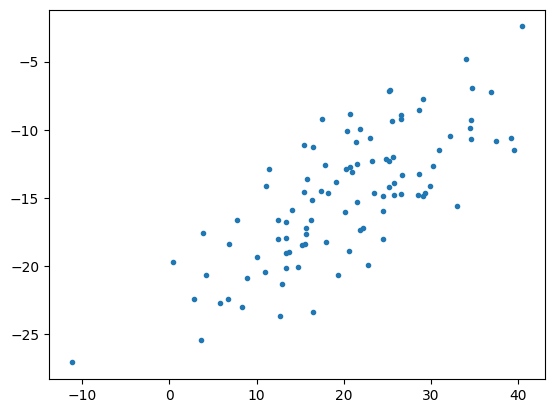

In [65]:
make_scatter(pca_data)

In [67]:
def de_mean(data: List[Vector]) -> List[Vector]:
    mean = vector_mean(data)

    return [subtract(vector, mean) for vector in data]

pca_data_mean = de_mean(pca_data)

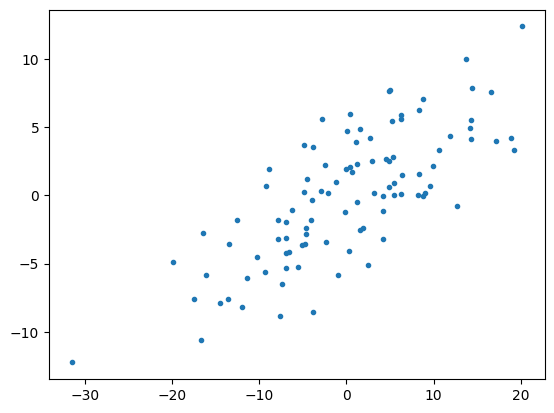

In [68]:
make_scatter(pca_data_mean)

In [ ]:
def direction(w: Vector) -> Vector:
    mag = magnitude(w)
    return [w_i / mag for w_i in w]

def direction_variance(data: List[Vector], w: Vector) -> float:
    w_dir = direction(w)

    return sum(dot(v, w_dir) ** 2 for v in data)

def direction_variance_gradient(data: List[Vector], w: Vector) -> Vector:
    w_dir = direction(w)

    return [sum(2 * dot(v, w_dir) * v[i] for v in data) for i in range(len(w))]

def first_principal_component(data: List[Vector],
                              n: int = 100,
                              step_size: float = 0.1) -> Vector:
    
    guess = [1.0 for _ in data[0]]
    with tqdm.trange(n) as t:
        for _ in t:
            dv = direction_variance(data, guess)
            gradient = direction_variance_gradient(data, guess)
            guess = gradient_step(guess, gradient, step_size)
            t.set_description(f"dv: {dv:3f}")

    return direction(guess)



In [72]:
def project(v: Vector, w: Vector) -> Vector:
    projection_length = dot(v, w)

    return scalar_multiply(projection_length, w)

def remove_projection_from_vector(v: Vector, w: Vector) -> Vector:

    return subtract(v, project(v, w))

def remove_projection(data: List[Vector], w: Vector) -> List[Vector]:

    return [remove_projection_from_vector(v, w) for v in data]

dv: 10279.150840: 100%|██████████| 100/100 [00:00<00:00, 680.35it/s]


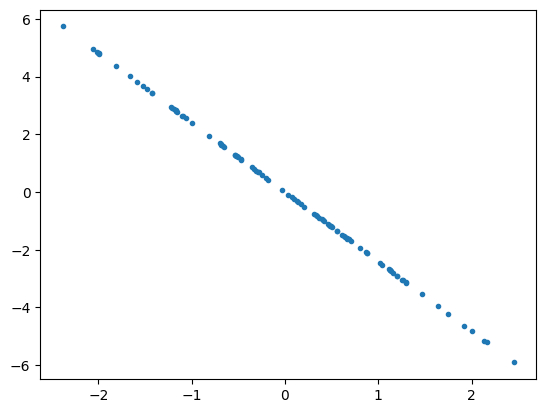

In [78]:
pca_data_first_pc = first_principal_component(pca_data_mean)
pca_data_first_pc = remove_projection(pca_data_mean, pca_data_first_pc)

make_scatter(pca_data_first_pc)

In [73]:
def pca(data: List[Vector], num_components: int) -> List[Vector]:
    components: List[Vector] = []

    for _ in range(num_components):
        component = first_principal_component(data)
        components.append(component)
        data = remove_projection(data, component)

    return components

In [79]:
def transform_vetor(v: Vector, components: List[Vector]) -> Vector:
    return [dot(v, w) for w in components]

def transform(data: Vector, components: List[Vector]) -> Vector:
    return [transform_vetor(v, components) for v in data]

In [80]:
de_meaned = de_mean(pca_data)
fpc = first_principal_component(de_meaned)

dv: 10279.150840: 100%|██████████| 100/100 [00:00<00:00, 609.76it/s]
